# Schneider Electric European Hackathon

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data
1. We'll use VGG16 for transfer learning CNN model and then we will evaluate its performances.
1. We will then use the output of this model and then concatenate with remaining spacial features and year variable as features for our final random forest classifier.

# Import Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn; sn.set(font_scale=1.4)
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                

2022-11-19 22:29:26.925469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class_names = ['Plantation', 'Grassland/Shrubland', 'Smallholder Agriculture']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
train_meta_data = pd.read_csv("train.csv")
test_meta_data = pd.read_csv("test.csv")

In [4]:
train_meta_data.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


# Loading the Data

In [5]:
"""
    Load the train data:
"""
# Iterate through training Set
images = []
labels = []
latitudes = []
longitudes = []
years = []
for index, row in train_meta_data.iterrows():

    # Get the path name and label of the image
    img_path = row['example_path']
    label = row['label']
    latitude = row['latitude']
    longitude = row['longitude']
    year = row['year']
    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)

    # Append the image and its corresponding label to the output
    images.append(image)
    labels.append(label)
    latitudes.append(latitude)
    longitudes.append(longitude)
    years.append(year)

    #Augment Data to Avoid Overfitting and also to increase training data set

    #90_ClockWise
    image_90_C = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    images.append(image_90_C)
    labels.append(label)
    latitudes.append(latitude)
    longitudes.append(longitude)
    years.append(year)

    #90_AntiClockWise
    image_90_AC = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    images.append(image_90_AC)
    labels.append(label)
    latitudes.append(latitude)
    longitudes.append(longitude)
    years.append(year)

    #Flip Vertically
    image_v = cv2.flip(image, 0)
    images.append(image_v)
    labels.append(label)
    latitudes.append(latitude)
    longitudes.append(longitude)
    years.append(year)

    #Flip Horizontally
    image_h = cv2.flip(image, 1)
    images.append(image_h)
    labels.append(label)
    latitudes.append(latitude)
    longitudes.append(longitude)
    years.append(year)

    #Flip Vertially & Horizontally
    image_vh = cv2.flip(image, -1)
    images.append(image_vh)
    labels.append(label)
    latitudes.append(latitude)
    longitudes.append(longitude)
    years.append(year)

train_images = np.array(images, dtype = 'float32')
train_labels = np.array(labels, dtype = 'int32')
train_latitudes = np.array(latitudes, dtype = 'float32')
train_longitudes = np.array(longitudes, dtype = 'float32')
train_years = np.array(years, dtype = 'int32')

### We split the data into train and validation to access the performance of model on validation dataset

In [6]:
X_train, X_validation, latitudes_train, latitudes_validation, longitudes_train, longitudes_validation, \
years_train, years_validaiton, y_train, y_validation = train_test_split(train_images, train_latitudes, train_longitudes,train_years, \
                                                        train_labels, test_size=0.2, random_state=10)

In [7]:
"""
    Load the test data:
"""
# Iterate through test Set
images = []
test_latitudes = []
test_longitudes = []
test_years = []
for index, row in test_meta_data.iterrows():

    # Get the path name and label of the image
    img_path = row['example_path']
    latitude = row['latitude']
    longitude = row['longitude']
    year = row['year']
    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)

    # Append the image and its corresponding label to the output
    images.append(image)
    test_latitudes.append(latitude)
    test_longitudes.append(longitude)
    test_years.append(year)
    
test_images = np.array(images, dtype = 'float32')
test_latitudes = np.array(test_latitudes, dtype = 'float32')
test_longitudes = np.array(test_longitudes, dtype = 'float32')
test_years = np.array(test_years, dtype = 'int32')


# Let's explore the dataset
We can ask ourselves:
* How many training examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [8]:
n_train = y_train.shape[0]
n_validation = y_validation.shape[0]
n_test = test_images.shape[0]
print ("Number of training examples: {}".format(n_train))
print ("Number of Validation examples: {}".format(n_validation))
print ("Number of test examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 8227
Number of Validation examples: 2057
Number of test examples: 635
Each image is of size: (150, 150)


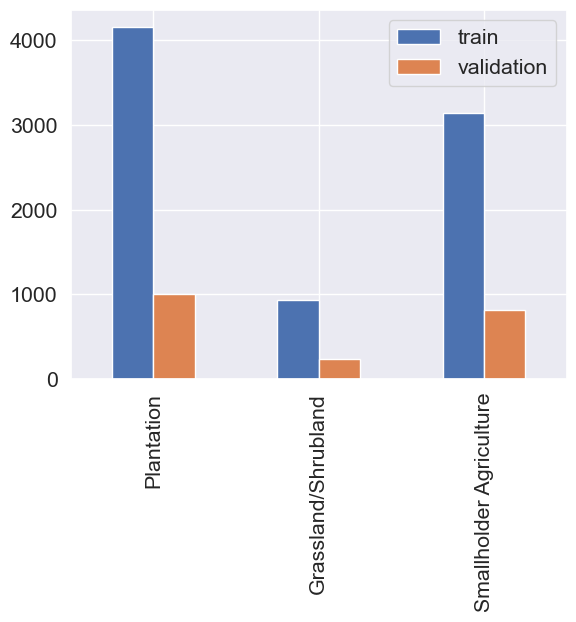

In [9]:
import pandas as pd

_, train_counts = np.unique(y_train, return_counts=True)
_, validation_counts = np.unique(y_validation, return_counts=True)
pd.DataFrame({'train': train_counts,'validation': validation_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

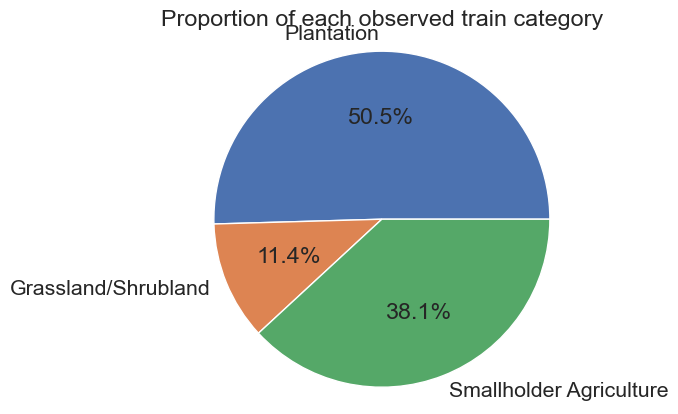

In [10]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed train category')
plt.show()

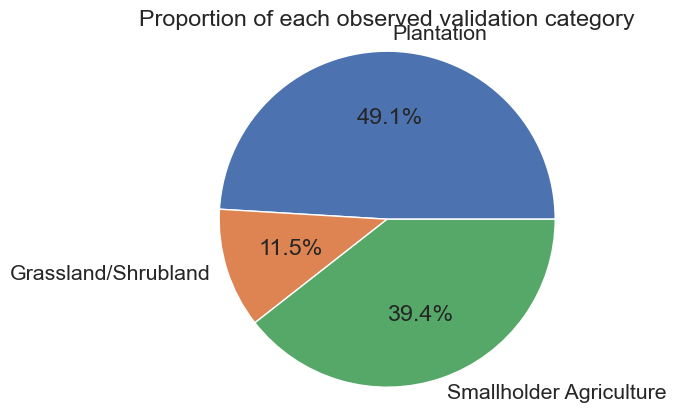

In [11]:
plt.pie(validation_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed validation category')
plt.show()

### Data is little unbalanced

## Good practice: scale the data

In [12]:
X_train = X_train / 255.0 
X_validation = X_validation / 255.0
test_images = test_images / 255.0

# Feature extraction with VGG ImageNet

In [13]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

2022-11-19 22:37:43.284474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
train_features = model.predict(X_train)
validation_features = model.predict(X_validation)
test_features = model.predict(test_images)

20/20 [==============================] - 35s 2s/step


## Visualize the features through PCA

In [15]:
n_train, x, y, z = train_features.shape
n_validation, x, y, z = validation_features.shape
numFeatures = x * y * z

In [16]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

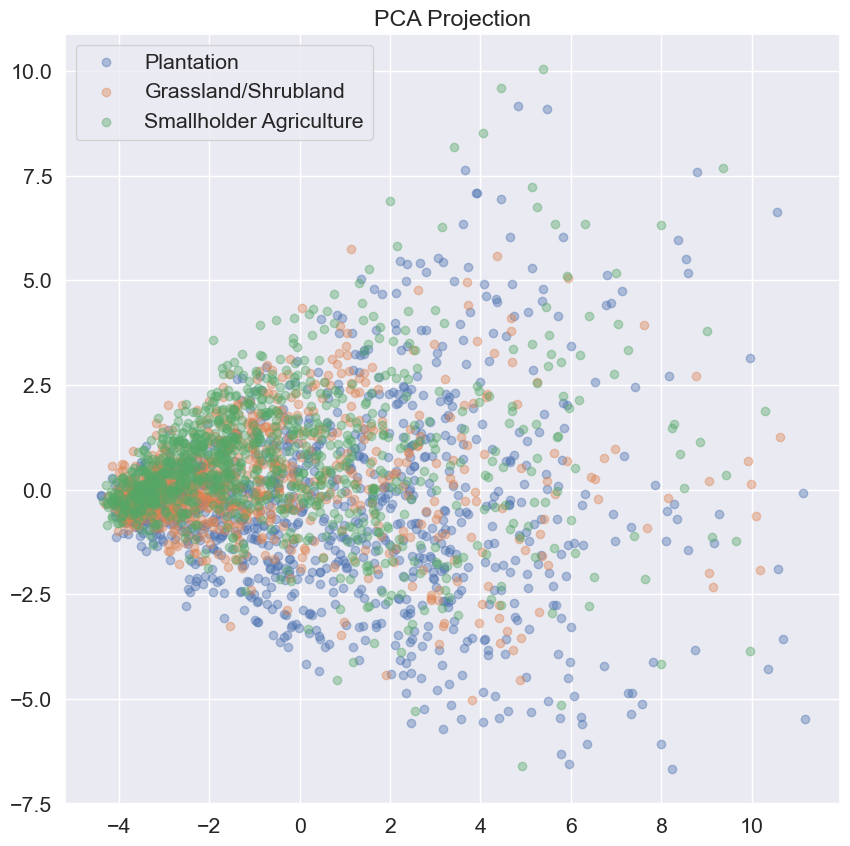

In [17]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[y_train == i][:1000], C2[y_train == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [18]:
train_features.shape

(8227, 4, 4, 512)

In [19]:
from keras import backend as K
def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [78]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])

history2 = model2.fit(train_features, y_train, batch_size=128, epochs=60, validation_split = 0.3)

Epoch 1/60
45/45 [==============================] - 1s 8ms/step - loss: 0.9029 - accuracy: 0.5952 - val_loss: 0.8284 - val_accuracy: 0.6501
Epoch 2/60
45/45 [==============================] - 0s 6ms/step - loss: 0.8113 - accuracy: 0.6506 - val_loss: 0.8092 - val_accuracy: 0.6318
Epoch 3/60
45/45 [==============================] - 0s 6ms/step - loss: 0.7668 - accuracy: 0.6810 - val_loss: 0.7701 - val_accuracy: 0.6772
Epoch 4/60
45/45 [==============================] - 0s 6ms/step - loss: 0.7379 - accuracy: 0.7032 - val_loss: 0.7675 - val_accuracy: 0.6736
Epoch 5/60
45/45 [==============================] - 0s 7ms/step - loss: 0.7188 - accuracy: 0.7009 - val_loss: 0.7506 - val_accuracy: 0.6881
Epoch 6/60
45/45 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.7155 - val_loss: 0.8229 - val_accuracy: 0.6391
Epoch 7/60
45/45 [==============================] - 0s 6ms/step - loss: 0.6800 - accuracy: 0.7197 - val_loss: 0.7408 - val_accuracy: 0.6910
Epoch 8/60
45/45 [==

We should evaluate the model performance on test set

In [79]:
validaton_loss = model2.evaluate(validation_features, y_validation)

65/65 [==============================] - 0s 2ms/step - loss: 0.9571 - accuracy: 0.6947


In [80]:
train_predictions = model2.predict(train_features)  
train_pred_labels = np.argmax(train_predictions, axis = 1)

258/258 [==============================] - 0s 1ms/step


In [81]:
predictions = model2.predict(validation_features)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

65/65 [==============================] - 0s 2ms/step


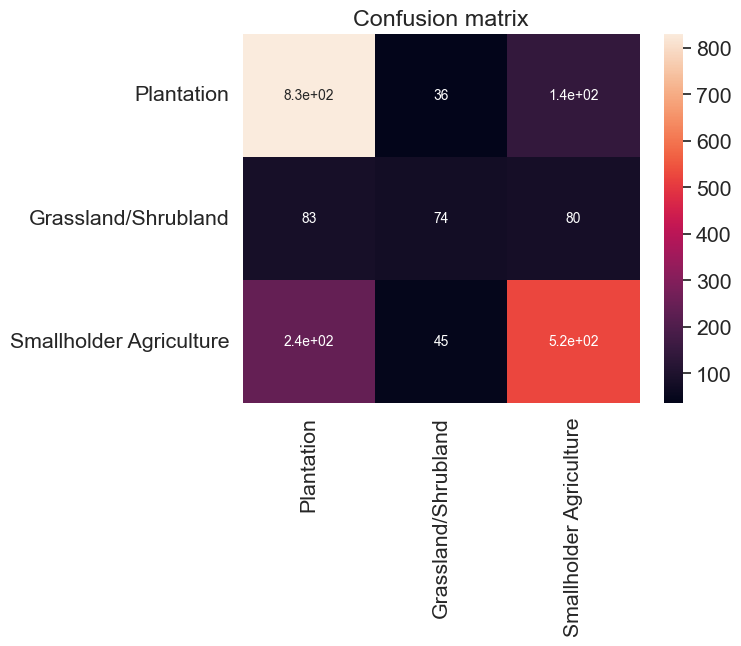

In [82]:
CM = confusion_matrix(y_validation, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [83]:
print("Train Accuracy : {}".format(accuracy_score(y_train, train_pred_labels)))

Train Accuracy : 0.8242372675337304


In [84]:
print("Validation Accuracy : {}".format(accuracy_score(y_validation, pred_labels)))

Validation Accuracy : 0.6947010209042295


In [85]:
print("Train F1-Score : {}".format(f1_score(y_train, train_pred_labels, average='macro')))

Train F1-Score : 0.7736661101747084


In [86]:
print("Validation F1-Score : {}".format(f1_score(y_validation, pred_labels, average='macro')))

Validation F1-Score : 0.6061025770477048


### We see that we achieve a F1-Score of 0.56 on the validation data.

### We would like to use latitude, longitude and year information to enhance our model 

In [87]:
train_output = model2.predict(train_features)
validation_output = model2.predict(validation_features)
test_output = model2.predict(test_features)

20/20 [==============================] - 0s 3ms/step


In [88]:
year_train_dummies = pd.get_dummies(years_train,drop_first=True)
year_validation_dummies = pd.get_dummies(years_validaiton,drop_first=True)
year_test_dummies = pd.get_dummies(test_years,drop_first=True)

In [144]:
train_transformed_data = np.column_stack((train_output, latitudes_train,longitudes_train,year_train_dummies))
validation_transformed_data = np.column_stack((validation_output, latitudes_validation,longitudes_validation,year_validation_dummies))
test_transformed_data = np.column_stack((test_output, test_latitudes,test_longitudes,year_test_dummies))


In [145]:
clf=RandomForestClassifier(max_depth = 10, random_state=0)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_transformed_data,y_train)

y_pred=clf.predict(validation_transformed_data)

In [146]:
y_train_pred = clf.predict(train_transformed_data)

In [147]:
y_test_pred = clf.predict(test_transformed_data)

In [148]:
from sklearn.metrics import accuracy_score
print("Train Accuracy : {}".format(accuracy_score(y_train, y_train_pred)))

Train Accuracy : 0.9054333292816337


In [149]:

print("Validation Accuracy : {}".format(accuracy_score(y_validation, y_pred)))

Validation Accuracy : 0.7520661157024794


In [150]:
print("Train F1-Score : {}".format(f1_score(y_train, y_train_pred, average='macro')))

Train F1-Score : 0.895869759701919


In [151]:
print("Validation F1-Score : {}".format(f1_score(y_validation, y_pred, average='macro')))

Validation F1-Score : 0.7021956044610116


In [152]:
y_test_pred.shape

(635,)

In [287]:
df = pd.DataFrame({'target':y_test_pred})
df.to_json('predictions.json')